# Random Imputation (Random Value Imputation)

Random Imputation replaces missing values by randomly drawing values from the **existing observed values** of the same feature.

Unlike mean or median imputation, random imputation **does not reduce variance** and attempts to preserve the true statistical properties of the data.

---

## Core Idea

Instead of inserting a fixed statistic (mean / median):

- We sample from the **empirical distribution** of the feature.
- Each missing value gets a *realistic* value already present in the data.

Mathematically:

Let  
Observed values = \( X_{obs} \)  
Missing values = \( X_{miss} \)

Then:

\[
x_{miss} \sim P(X_{obs})
\]

---

## Why Random Imputation Works

### 1. Preserves Variance (Key Advantage)

Mean imputation collapses variance:

\[
Var(X_{imputed}) < Var(X_{original})
\]

Random imputation **maintains variance** because:
- Imputed values come from the same spread as original data.

This is critical for:
- Linear Regression  
- Logistic Regression  
- PCA  
- Distance-based models  

---

### 2. Preserves Distribution Shape

- Mean/median insert a spike at one value.
- Random imputation keeps the histogram shape intact.

✅ Bell curve remains bell-shaped  
✅ Skewed distribution remains skewed

---

### 3. Better Covariance & Correlation Retention

Covariance depends on variance.

Since random imputation preserves variance:
- Correlation among variables is impacted **much less** than mean/median.
- Linear relationships remain more stable.

This explains why it is **well suited for linear models**.

---

### 4. Well-suited for Linear Models

Linear models assume:
- Consistent variance
- Stable covariance structure

Random imputation:
- Maintains these assumptions better than constant imputations
- Reduces bias in coefficient estimation

---

## Random Imputation vs Mean Imputation (Critical Difference)

| Property | Mean Imputation | Random Imputation |
|--------|----------------|------------------|
| Variance | Reduced | Preserved |
| Distribution | Distorted (spike) | Preserved |
| Covariance | Altered | Mostly preserved |
| Linear models | Weak | Strong |
| Randomness | No | Yes |

---

## Subtypes of Random Imputation

### 1. Simple Random Imputation (Unconditional)

- Sample from full non-missing distribution.

```python
import numpy as np

mask = df['Age'].isna()
df.loc[mask, 'Age'] = np.random.choice(
    df.loc[~mask, 'Age'],
    size=mask.sum(),
    replace=True
)
```

✅ Simple  
❌ Ignores structure in data  

---

### 2. Random Imputation with Missing Indicator (Recommended)

Add a binary flag to preserve missingness information.

```python
df['Age_missing'] = df['Age'].isna().astype(int)
```

Why this matters:
- Models learn both *value* and *fact of missingness*
- Especially effective for tree models

---

### 3. Stratified Random Imputation

Random sampling **within groups** (e.g., Sex, Class, Category).

Example:
- Age imputed separately for Male and Female.

```python
for g in df['Sex'].unique():
    mask = (df['Sex'] == g) & (df['Age'].isna())
    pool = df.loc[(df['Sex'] == g) & df['Age'].notna(), 'Age']
    df.loc[mask, 'Age'] = np.random.choice(pool, size=mask.sum(), replace=True)
```

✅ Reduces bias  
✅ Better than global random sampling  

---

### 4. Range-based Random Imputation

Sometimes we restrict sampling range (e.g. 60–70 as in your image).

Used when:
- Domain knowledge exists
- Extreme values must be avoided

```python
pool = df.loc[df['Age'].between(60, 70), 'Age']
```

⚠ Use carefully — can introduce bias.

---

## sklearn vs pandas Implementation

### Pandas
- Fast
- Manual
- Easy to customize

### sklearn
- Pipeline-safe
- Prevents data leakage
- Less flexible by default

sklearn does **NOT** have native random imputation  
You must implement via:
- Custom transformer
- `IterativeImputer` with stochastic setting

---

## Memory Consideration (Production Note)

Random imputation **requires storing training data**:

- You must retain observed values from training set.
- Incoming data draws samples from training distribution.

❗ This is a real deployment constraint.

---

## Assumptions

| Missingness Type | Suitability |
|------------------|-------------|
| MCAR | Excellent |
| MAR | Good (with stratification) |
| MNAR | Weak |

If missingness is meaningful → use:
- End-of-distribution imputation
- Missing indicator features

---

## Disadvantages

1. Introduces randomness → results vary unless seed is fixed  
2. Not deterministic by default  
3. Harder to debug  
4. Needs careful pipeline handling  
5. Can break relationships if sample size is small  

---

## Best Practices

1. Always fix random seed for reproducibility  
2. Use stratified or conditional random imputation when possible  
3. Combine with missing-indicator features  
4. Avoid on extremely small datasets  
5. Evaluate against median/knn/mice using validation



In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train.csv', usecols=['Age', 'Fare', 'Survived'])
df.head(15)

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500
5,0,NaN,8.4583
6,0,54.0,51.8625
7,0,2.0,21.0750
8,1,27.0,11.1333
9,1,14.0,30.0708


In [34]:
df.isnull().mean()

,0
Survived,0.000000
Age,0.198653
Fare,0.000000


In [35]:
X = df.drop('Survived', axis=1 ) # column axis = 1

y = df['Survived']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [37]:
X_train['Age_imputed'] = X_train['Age']
X_test['Age_imputed'] = X_test['Age']

In [38]:
X_train['Age_imputed' ][X_train['Age_imputed'].isnull()] = X_train['Age'].dropna().sample(X_train['Age'].isnull().sum()).values
X_test['Age_imputed' ][X_test['Age_imputed'].isnull()] = X_train['Age'].dropna().sample(X_test['Age'].isnull().sum()).values

/tmp/ipython-input-2190221190.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_train['Age_imputed' ][X_train['Age_imputed'].isnull()] = X_train['Age'].dropna().sample(X_train['Age'].isnull().sum()).values
/tmp/ipython-input-2190221190.p

In [39]:
X_train

,Age,Fare,Age_imputed
30,40.0,27.7208,40.0
10,4.0,16.7000,4.0
873,47.0,9.0000,47.0
182,9.0,31.3875,9.0
876,20.0,9.8458,20.0
...,...,...,...
534,30.0,8.6625,30.0
584,NaN,8.7125,19.0
493,71.0,49.5042,71.0
527,NaN,221.7792,16.0


/tmp/ipython-input-3988573734.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train['Age'],label='Original')
/tmp/ipython-input-3988573734.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train['Age_imputed'],label = 'Imputed')


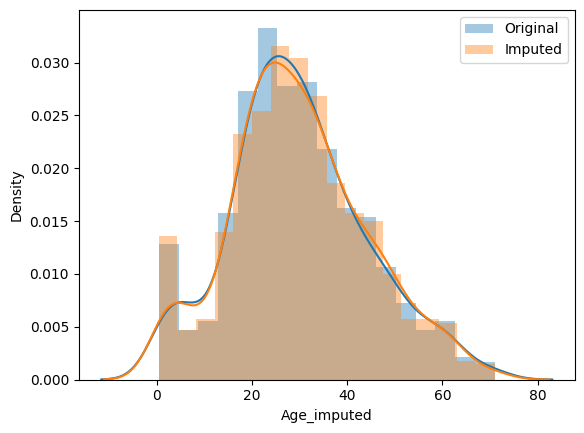

In [40]:
sns.distplot(X_train['Age'],label='Original')
sns.distplot(X_train['Age_imputed'],label = 'Imputed')

plt.legend()
plt.show()

In [41]:
print('Origina1 variable variance:', X_train['Age'].var())
print('Variance after random:', X_train['Age_imputed'].var())

Origina1 variable variance: 204.3495133904614
Variance after random: 204.67598337343352


In [42]:
X_train[['Age', 'Age_imputed']].cov()

,Age,Age_imputed
Age,204.349513,204.349513
Age_imputed,204.349513,204.675983


<Axes: >

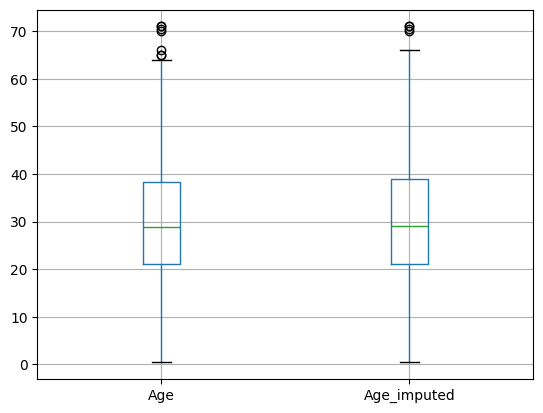

In [43]:
X_train[['Age', 'Age_imputed']].boxplot()

In [44]:
# the same row, the same Fare → same seed → same sampled age.

# sampled_value = X_train['Age'].dropna().sample(
#     1,
#     random_state=int(observation['Fare'])
# )


In [45]:
data = pd.read_csv('house-train.csv',usecols=['GarageQual','FireplaceQu', 'SalePrice'])

In [46]:
data


,FireplaceQu,GarageQual,SalePrice
0,NaN,TA,208500
1,TA,TA,181500
2,TA,TA,223500
3,Gd,TA,140000
4,TA,TA,250000
...,...,...,...
1455,TA,TA,175000
1456,TA,TA,210000
1457,Gd,TA,266500
1458,NaN,TA,142125


In [47]:
X = data
y = data['SalePrice']

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

X_train['GarageQual_imputed'] = X_train['GarageQual']
X_test['GarageQual_imputed'] = X_test['GarageQual']

X_train['FireplaceQu_imputed'] = X_train['FireplaceQu']
X_test['FireplaceQu_imputed'] = X_test['FireplaceQu']

In [59]:
X_train['GarageQual_imputed'][X_train['GarageQual_imputed'].isnull()]=X_train['GarageQual'].dropna().sample(X_train['GarageQual'].isnull().sum()).values
X_test['GarageQual_imputed'][X_test['GarageQual_imputed'].isnull()]=X_train['GarageQual'].dropna().sample(X_test['GarageQual'].isnull().sum()).values

X_train['FireplaceQu_imputed'][X_train['FireplaceQu_imputed'].isnull()] = X_train['FireplaceQu'].dropna().sample(X_train['FireplaceQu'].isnull().sum()).values
X_test['FireplaceQu_imputed'][X_test['FireplaceQu_imputed'].isnull()] =X_train['FireplaceQu'].dropna().sample(X_test['FireplaceQu'].isnull().sum()).values

/tmp/ipython-input-3522924355.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_train['GarageQual_imputed'][X_train['GarageQual_imputed'].isnull()]=X_train['GarageQual'].dropna().sample(X_train['GarageQual'].isnull().sum()).values
/tmp/i

In [60]:
temp = pd.concat(
[
X_train['GarageQual'].value_counts() /len(X_train['GarageQual'].dropna()),
X_train['GarageQual_imputed'].value_counts() / len(X_train)
],
axis=1)

temp.columns = ['original', 'imputed']

In [61]:
temp

,original,imputed
TA,0.951043,0.949486
Fa,0.037171,0.037671
Gd,0.009973,0.010274
Po,0.000907,0.000856
Ex,0.000907,0.001712


In [62]:
temp = pd.concat(
[
X_train['FireplaceQu'].value_counts() / len(X_train['FireplaceQu'].dropna()),
X_train['FireplaceQu_imputed'].value_counts() / len(df)
],
axis=1)

temp.columns = ['original', 'imputed']

temp

,original,imputed
Gd,0.494272,0.649832
TA,0.412439,0.538721
Fa,0.040917,0.053872
Po,0.027823,0.037037
Ex,0.024550,0.031425


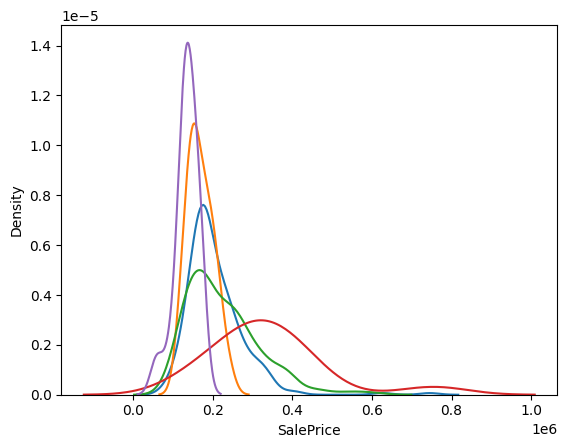

In [65]:
for category in X_train['FireplaceQu'].dropna().unique():
    sns.kdeplot(X_train[X_train['FireplaceQu'] == category]['SalePrice'], label=category)
plt.show()

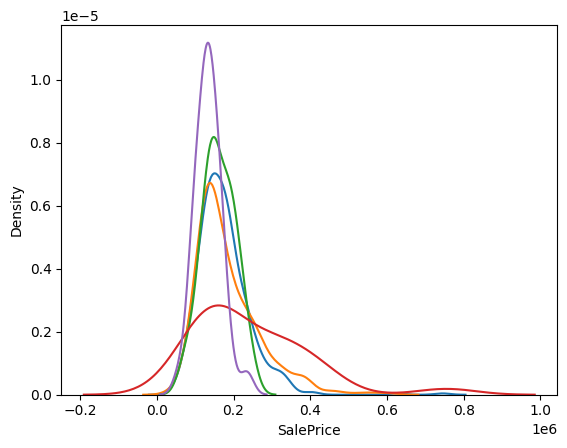

In [70]:
for category in X_train['FireplaceQu_imputed'].dropna().unique():
    sns.kdeplot(X_train[X_train['FireplaceQu_imputed'] == category]['SalePrice'],label=category)
plt.show()

# Missing indicator

In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.impute import MissingIndicator, SimpleImputer

df = pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])

df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [4]:
X = df.drop(columns=['Survived'])
y = df['Survived' ]

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

X_train.head()

,Age,Fare
30,40.0,27.7208
10,4.0,16.7000
873,47.0,9.0000
182,9.0,31.3875
876,20.0,9.8458


In [5]:
si = SimpleImputer()
X_train_trf = si.fit_transform(X_train)
X_test_trf = si.transform(X_test)

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train_trf,y_train)

LogisticRegression()

In [6]:
y_pred = clf.predict(X_test_trf)

from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6145251396648045

In [7]:
mi = MissingIndicator()

mi.fit(X_train)

MissingIndicator()

In [8]:
X_train_missing = mi.transform(X_train)

X_test_missing = mi.transform(X_test)

X_train['Age_NA'] = X_train_missing

X_test['Age_NA'] = X_test_missing

In [10]:
si = SimpleImputer()

X_train_trf2 = si.fit_transform(X_train)
X_test_trf2 = si.transform(X_test)


In [11]:

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train_trf2,y_train)

y_pred = clf.predict(X_test_trf2)

from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6312849162011173

using add_indicator=True

In [17]:
si = SimpleImputer(add_indicator=True)

X_train = si.fit_transform(X_train)

X_test = si.transform(X_test)

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

clf.fit(X_train_trf2,y_train)

y_pred = clf.predict(X_test_trf2)


In [18]:

from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.6312849162011173

### Automatically Selecting the Best Imputation Strategy

**Definition**
- Imputation technique is selected automatically using model performance.
- Imputation is treated as a **hyperparameter**, not a fixed preprocessing step.

---

### Why automatic selection is needed
- Different imputers affect:
  - data distribution
  - variance
  - correlations
  - model predictions
- No imputation method works best for every dataset.
- Manual selection is assumption-driven and unreliable.

---

### Core idea
- Combine **imputer + model** in a single pipeline.
- Use **cross-validation** to evaluate multiple imputers.
- Select the imputer with the **best validation score**.

---

### Tools used
- `Pipeline`
- `GridSearchCV`
- Evaluation metrics (Accuracy, F1-score, RMSE, AUC)

---

### Step-by-step workflow
1. Split data into training and testing sets.
2. Create a pipeline:
   - Step 1: Imputer  
   - Step 2: Machine Learning model
3. Define a set of candidate imputers.
4. Run GridSearchCV with cross-validation.
5. Identify the imputer with highest validation performance.
6. Refit the final pipeline on training data.

---

### Common imputation candidates
- Mean imputation  
- Median imputation  
- Most frequent imputation  
- Random sample imputation  
- KNN imputation  
- Iterative imputation (MICE)

---

### Model dependency
- Linear models → Mean / Median + missing indicator  
- Tree-based models → Random or end-of-distribution imputation  
- Distance-based models → KNN imputation  

---

### Advantages
- Data-driven and objective
- Prevents data leakage
- Model-specific optimization
- Reproducible results
- Widely used in AutoML systems

---

### Disadvantages
- Computationally expensive
- Requires sufficient data
- Harder to interpret
- Not ideal for very small datasets

---

### Best practices
- Keep imputation inside the pipeline
- Never fit imputers on test data
- Use correct evaluation metric
- Limit search space to relevant imputers

---

### Summary
- Automatic imputation selection replaces guesswork with validation.
- GridSearchCV selects the imputer that maximizes performance.
- This is a production-grade machine learning practice.


In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [20]:
df = pd.read_csv('train.csv')

df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
df.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [22]:
df.isnull().mean()

,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.198653
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


In [24]:
df.drop(columns=['PassengerId', 'Name','Ticket','Cabin'], inplace=True)

In [27]:
X = df.drop(columns=['Survived'])
y = df ['Survived' ]

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
30,1,male,40.0,0,0,27.7208,C
10,3,female,4.0,1,1,16.7000,S
873,3,male,47.0,0,0,9.0000,S
182,3,male,9.0,4,2,31.3875,S
876,3,male,20.0,0,0,9.8458,S


In [28]:
numerical_features = ['Age', 'Fare']
numerical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

categorical_features = ['Embarked', 'Sex']
categorical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='most_frequent')),
('ohe',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
    ])

clf = Pipeline(steps=[
('preprocessor', preprocessor),
('classifier', LogisticRegression())
])

In [29]:
from sklearn import set_config

set_config(display='diagram')
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked', 'Sex'])])),
                ('classifier', LogisticRegression())])

In [40]:
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
    'classifier__C': [0.1, 1.0, 10, 100]
}


In [41]:
grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

In [42]:
grid_search.fit(X_train, y_train)

print(f"Best params:")
print(grid_search.best_params_)

Best params:
{'classifier__C': 1.0, 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'mean'}


In [43]:

print(f"Internal CV score: {grid_search.best_score_:.3f}")

Internal CV score: 0.788


In [48]:
import pandas as pd

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)

cv_results[
    [
        'param_classifier__C',
        'param_preprocessor__cat__imputer__strategy',
        'param_preprocessor__num__imputer__strategy',
        'mean_test_score'
    ]
].head(20)


,param_classifier__C,param_preprocessor__cat__imputer__strategy,param_preprocessor__num__imputer__strategy,mean_test_score
7,1.0,constant,median,0.787852
6,1.0,constant,mean,0.787852
5,1.0,most_frequent,median,0.787852
4,1.0,most_frequent,mean,0.787852
11,10.0,constant,median,0.787852
10,10.0,constant,mean,0.787852
9,10.0,most_frequent,median,0.787852
8,10.0,most_frequent,mean,0.787852
12,100.0,most_frequent,mean,0.787852
13,100.0,most_frequent,median,0.787852
